# Исследование тарифов связи

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math

## Описание проекта


Мы - аналитики федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

**Тариф «Смарт»**
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
 - минута разговора: 3 рубля
 - сообщение: 3 рубля
 - 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
 - минута разговора: 1 рубль
 - сообщение: 1 рубль
 - 1 Гб интернет-трафика: 150 рублей


### Описание данных

Таблица **`users`** (информация о пользователях):

- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

Таблица **`calls`** (информация о звонках):

- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

Таблица **`messages`** (информация о сообщениях):

- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

Таблица **`internet`** (информация об интернет-сессиях):

- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

Таблица **`tariffs`** (информация о тарифах):

- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [2]:
df_tariffs = pd.read_csv('/datasets/tariffs.csv')  
df_calls = pd.read_csv('/datasets/calls.csv')  
df_internet = pd.read_csv('/datasets/internet.csv') 
df_messages = pd.read_csv('/datasets/messages.csv') 
df_users = pd.read_csv('/datasets/users.csv')  

## Обзор данных

In [3]:
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [4]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [6]:
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [7]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [8]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [9]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [10]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [11]:
df_users.info()
df_users['churn_date'].isna().mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


0.924

Предварительно можно сделать несколько выводов о данных:

- Неожиданных пропусков в таблицах нет;
- В таблице `df_users` по столбцу `churn_date` видно, что почти 8% перестали пользоваться тарифом к моменту выгрузки данных;
- В таблице `df_internet` есть лишний столбец `Unnamed: 0`;
- Во всех таблицах столбцы с датами имеют тип `object`.


## Подготовка данных

Удалим лишний столбец `Unnamed: 0` в `df_internet`:

In [12]:
df_internet = df_internet.drop(columns='Unnamed: 0')  

In [13]:
df_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Изменим тип данных в столбцах с датами в datetime:

In [14]:
try:
    df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
    df_messages ['message_date'] = pd.to_datetime(df_messages ['message_date'], format='%Y-%m-%d')
    df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
    df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
    df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')    
except:
    print('error')

Округлим длительность звонков так, как того требует тарифный план: "Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута."    

In [15]:
df_calls['duration'] = df_calls['duration'].apply(math.ceil)

In [16]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


В ходе проверки категориальных и количественных перменных в таблицах (с помощью методов `unique` и `describe`) дебликатов и аномалий найдено не было (в тетради не отображено).

In [17]:
print(df_calls.duplicated().sum(), df_internet.duplicated().sum(), 
      df_messages.duplicated().sum(), df_users.duplicated().sum())

0 0 0 0


### Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя

In [18]:
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month
df_calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


In [19]:
calls_pivot = df_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum', 'count']).reset_index()

In [20]:
calls_pivot = calls_pivot.merge(df_users[['tariff', 'city', 'user_id']],  how='inner', on='user_id')

/opt/conda/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [21]:
calls_pivot = calls_pivot.rename(columns={('month', '') : 'month'})
calls_pivot = calls_pivot.rename(columns={('sum', 'duration') : 'sum_minut'})
calls_pivot = calls_pivot.rename(columns={('count', 'duration') : 'count_calls'})
calls_pivot = calls_pivot.drop(columns=[('user_id', '')])  

In [22]:
calls_pivot.head()

,user_id,month,sum_minut,count_calls,tariff,city
0,1000,5,159,22,ultra,Краснодар
1,1000,6,172,43,ultra,Краснодар
2,1000,7,340,47,ultra,Краснодар
3,1000,8,408,52,ultra,Краснодар
4,1000,9,466,58,ultra,Краснодар


### Посчитаем количество отправленных сообщений по месяцам  для каждого пользователя

In [23]:
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month
df_messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [24]:
messages_pivot = df_messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count').reset_index()

In [25]:
messages_pivot = messages_pivot.merge(df_users[['tariff', 'city', 'user_id']], on='user_id')

In [26]:
messages_pivot = messages_pivot.rename(columns={'id' : 'count_sms'})

In [27]:
messages_pivot.head()

,user_id,month,count_sms,tariff,city
0,1000,5,22,ultra,Краснодар
1,1000,6,60,ultra,Краснодар
2,1000,7,75,ultra,Краснодар
3,1000,8,81,ultra,Краснодар
4,1000,9,57,ultra,Краснодар


### Посчитаем объем израсходованного интернет-трафика по месяцам для каждого пользователя

In [28]:
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month
df_internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


In [29]:
internet_pivot = df_internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()

In [30]:
internet_pivot = internet_pivot.merge(df_users[['tariff', 'city', 'user_id']], on='user_id')

In [31]:
internet_pivot['gb_used'] = internet_pivot['mb_used']/1024

Округлим веб-трафик так, как того требует тарифный план: "Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта." 

In [32]:
internet_pivot['gb_used'] = internet_pivot['gb_used'].apply(math.ceil)

In [33]:
internet_pivot.head()  

,user_id,month,mb_used,tariff,city,gb_used
0,1000,5,2253.49,ultra,Краснодар,3
1,1000,6,23233.77,ultra,Краснодар,23
2,1000,7,14003.64,ultra,Краснодар,14
3,1000,8,14055.93,ultra,Краснодар,14
4,1000,9,14568.91,ultra,Краснодар,15


### Посчитаем помесячную выручку с каждого пользователя

In [34]:
general_df = internet_pivot.merge(calls_pivot[['sum_minut', 'count_calls', 'user_id', 'month', 'tariff']], how='outer',  on=['user_id', 'month', 'tariff'])

In [35]:
general_df = general_df.merge(messages_pivot[['count_sms', 'user_id', 'month', 'tariff']], how='outer', on=['user_id', 'month', 'tariff'])

In [36]:
len(general_df['user_id'].unique())

498

In [37]:
general_df.head()

,user_id,month,mb_used,tariff,city,gb_used,sum_minut,count_calls,count_sms
0,1000,5,2253.49,ultra,Краснодар,3.0,159.0,22.0,22.0
1,1000,6,23233.77,ultra,Краснодар,23.0,172.0,43.0,60.0
2,1000,7,14003.64,ultra,Краснодар,14.0,340.0,47.0,75.0
3,1000,8,14055.93,ultra,Краснодар,14.0,408.0,52.0,81.0
4,1000,9,14568.91,ultra,Краснодар,15.0,466.0,58.0,57.0


In [38]:
general_df['minut'] = general_df['sum_minut']
general_df['sms'] = general_df['count_sms']
general_df['gb'] = general_df['gb_used']

Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика. Остаток умножим на значение из тарифного плана и прибавим абонентскую плату, соответствующую тарифному плану.

In [39]:
general_df.loc[general_df['tariff'] == 'smart', 'minut'] = (general_df['minut'] - 500) * 3
general_df.loc[general_df['tariff'] == 'smart', 'sms'] = (general_df['sms'] - 50) * 3
general_df.loc[general_df['tariff'] == 'smart', 'gb'] = (general_df['gb'] - 15) * 200

general_df.loc[general_df['tariff'] == 'ultra', 'minut'] = (general_df['minut'] - 3000) * 1 
general_df.loc[general_df['tariff'] == 'ultra', 'sms'] = (general_df['sms'] - 1000) * 1
general_df.loc[general_df['tariff'] == 'ultra', 'gb'] = (general_df['gb'] - 30) * 150 

In [40]:
general_df[['minut', 'sms', 'gb']] = general_df[['minut', 'sms', 'gb']].where(general_df[['minut', 'sms', 'gb']] >= 0, 0)

In [41]:
general_df['profit'] = general_df['gb'] + general_df['minut'] + general_df['sms']

In [42]:
general_df.loc[general_df['tariff'] == 'smart', 'profit'] = general_df['profit'] + 550 
general_df.loc[general_df['tariff'] == 'ultra', 'profit'] = general_df['profit'] + 1950

In [43]:
general_df = general_df.drop(columns=['sms', 'minut', 'gb', 'mb_used'])  

In [44]:
general_df.head()

,user_id,month,tariff,city,gb_used,sum_minut,count_calls,count_sms,profit
0,1000,5,ultra,Краснодар,3.0,159.0,22.0,22.0,1950.0
1,1000,6,ultra,Краснодар,23.0,172.0,43.0,60.0,1950.0
2,1000,7,ultra,Краснодар,14.0,340.0,47.0,75.0,1950.0
3,1000,8,ultra,Краснодар,14.0,408.0,52.0,81.0,1950.0
4,1000,9,ultra,Краснодар,15.0,466.0,58.0,57.0,1950.0


## Анализ данных

Изучим, сколько минут разговора, сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.

In [45]:
general_smart = general_df.query('tariff == "smart"')
general_ultra = general_df.query('tariff == "ultra"')

In [46]:
general_smart.head(3)

,user_id,month,tariff,city,gb_used,sum_minut,count_calls,count_sms,profit
8,1001,11,smart,Москва,18.0,430.0,59.0,NaN,1150.0
9,1001,12,smart,Москва,14.0,414.0,63.0,NaN,550.0
10,1002,6,smart,Стерлитамак,11.0,117.0,15.0,4.0,550.0


In [47]:
general_ultra.head(3)

,user_id,month,tariff,city,gb_used,sum_minut,count_calls,count_sms,profit
0,1000,5,ultra,Краснодар,3.0,159.0,22.0,22.0,1950.0
1,1000,6,ultra,Краснодар,23.0,172.0,43.0,60.0,1950.0
2,1000,7,ultra,Краснодар,14.0,340.0,47.0,75.0,1950.0


In [48]:
len(general_smart['user_id'].unique())

350

In [49]:
len(general_ultra['user_id'].unique())

148

Судя по результатам расчета уникальных идентификаторов, у тарифа "Смарт" почти в 3 раза больше пользователей, чем у тарифа "Ультра". Вероятно, результаты дальнейшего исследования для тарифа "Ультра" будут не такими точными, как у тарифа "Смарт", что стоит учесть.

Проведем анализ столбца с числом сообщений:

In [50]:
np.var(general_smart['count_sms'], ddof=1) #дисперсия

717.5942011753547

count    1922.000000
mean       38.716441
std        26.787949
min         1.000000
25%        17.000000
50%        34.000000
75%        55.000000
max       143.000000
Name: count_sms, dtype: float64

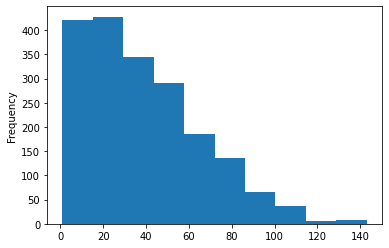

In [51]:
general_smart['count_sms'].plot(kind='hist')
general_smart['count_sms'].describe()

В основном, пользователями тарифа "Смарт" отправляется от 17 до 55 сообщений в месяц.

In [52]:
np.var(general_ultra['count_sms'], ddof=1)

2109.6591828651995

count    795.000000
mean      61.161006
std       45.931026
min        1.000000
25%       24.000000
50%       51.000000
75%       87.500000
max      224.000000
Name: count_sms, dtype: float64

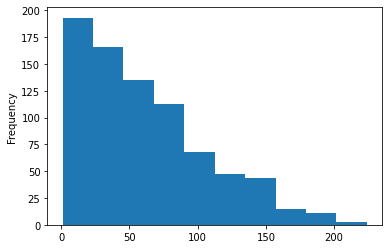

In [53]:
general_ultra['count_sms'].plot(kind='hist')
general_ultra['count_sms'].describe()

Пользователи тарифа "Ультра" отправляют больше сообщений в месяц: от 24 до 88, чаще всего.

<AxesSubplot:ylabel='Frequency'>

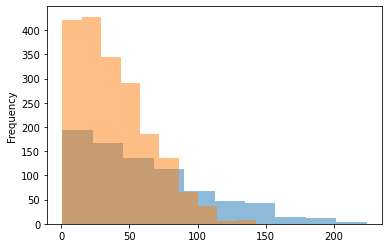

In [54]:
general_ultra['count_sms'].plot(kind='hist', alpha = 0.5)
general_smart['count_sms'].plot(kind='hist', alpha = 0.5)

Проведем анализ столбцов с количеством и длительностью звонков:

In [55]:
np.var(general_smart['sum_minut'], ddof=1)

35844.1895513438

In [56]:
general_smart['count_calls'].describe()

count    2223.000000
mean       58.621233
std        25.796101
min         1.000000
25%        40.000000
50%        60.000000
75%        76.000000
max       198.000000
Name: count_calls, dtype: float64

count    2223.000000
mean      419.062978
std       189.325618
min         0.000000
25%       285.000000
50%       423.000000
75%       545.500000
max      1435.000000
Name: sum_minut, dtype: float64

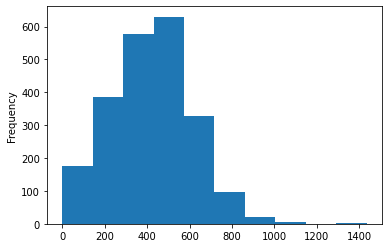

In [57]:
general_smart['sum_minut'].plot(kind='hist')
general_smart['sum_minut'].describe()

Пользователи тарифа "Смарт", в основном, расходуют от 285 до 545 минут в месяц, при количестве звонков от 40 до 76.

In [58]:
np.var(general_ultra['sum_minut'], ddof=1)

94203.41839614809

In [59]:
general_ultra['count_calls'].describe()

count    951.000000
mean      76.016824
std       42.403348
min        1.000000
25%       43.000000
50%       75.000000
75%      105.000000
max      244.000000
Name: count_calls, dtype: float64

count     951.000000
mean      545.451104
std       306.925754
min         0.000000
25%       310.000000
50%       528.000000
75%       756.500000
max      1673.000000
Name: sum_minut, dtype: float64

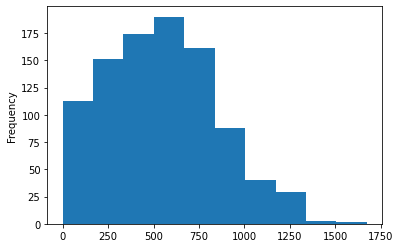

In [60]:
general_ultra['sum_minut'].plot(kind='hist')
general_ultra['sum_minut'].describe()

Пользователи тарифа "Ультра", в основном, расходуют от 310 до 756 минут в месяц, при количестве звонков от 43 до 105, что также больше, чем у пользователей тарифа "Смарт".

Проведем анализ столбца с объемом интернет-трафика:

In [61]:
np.var(general_smart['gb_used'], ddof=1)

32.92375582354312

count    2228.000000
mean       16.336176
std         5.737923
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: gb_used, dtype: float64

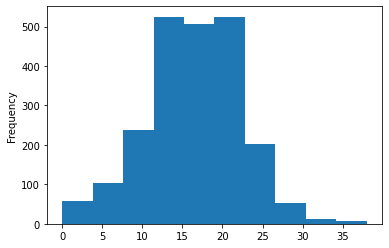

In [62]:
general_smart['gb_used'].plot(kind='hist')
general_smart['gb_used'].describe()

Для тарифа "Смарт" наиболее частое количество использованного трафика в диапазоне от 13 гб до 20 гб в месяц.

In [63]:
np.var(general_ultra['gb_used'], ddof=1)

94.14673405991682

count    975.000000
mean      19.694359
std        9.702924
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: gb_used, dtype: float64

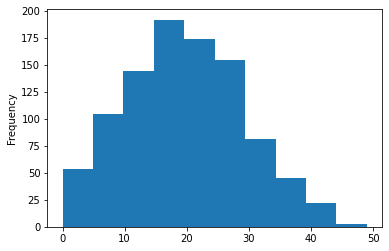

In [64]:
general_ultra['gb_used'].plot(kind='hist')
general_ultra['gb_used'].describe()

Для тарифа "Ультра" наиболее частое количество использованного трафика немного больше: от 12 гб до 27 гб в месяц.

Проведем анализ столбца с выручкой:

count    2229.000000
mean     1289.973531
std       818.404367
min       550.000000
25%       550.000000
50%      1023.000000
75%      1750.000000
max      6770.000000
Name: profit, dtype: float64

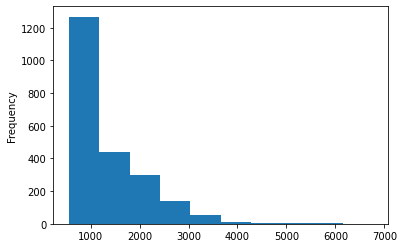

In [65]:
general_smart['profit'].plot(kind='hist')
general_smart['profit'].describe()

Для тарифа "Смарт", стоимость которого 550 рублей, наиболее частая выручка находится в диапазоне от 550 до 1750 руб. Медианное значение - 1023 руб., т.е., в основном, пользователям не хватает тарифного пакета.

count     985.000000
mean     2070.152284
std       376.187114
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: profit, dtype: float64

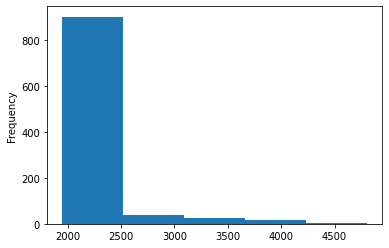

In [66]:
general_ultra['profit'].plot(kind='hist', bins=5)
general_ultra['profit'].describe()

Для тарифа "Ультра", наиболее частая выручка равна 1950 рублей, т.е. его стоимости, значит, пользователям обычно хватает объема тарифного пакета и они не переплачивают.

Исходя из анализа данных, можно заметить, что пользователям обоих тарифов обычно с большим запасом хватает объема бесплатного лимита на минуты и сообщения, а большинство переплат приходится на оплату дополнительного интернет-трафика.

## Проверка гипотез

### Проверим гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Для сравнения двух выборок воспользуемся методом `ttest_ind`, который дает возможность сравнить средние значения массивов между собой.

- Нулевая гипотеза - средние выручки пользователей тарифов «Ультра» и «Смарт» равны;
- Альтернативная гипотеза - выручки не равны.

Дисперсии выборок считаем неравными - ранее мы находили стандартные отклонения в выборках по выручке и выяснили, что их стандартные отклонения отличаются примерно в 2 раза, соответственно дисперсии вряд ли будут примерно равны.

In [67]:
alpha = 0.05 # критический уровень статистической значимости
             # если p-value окажется меньше него - отвегнем гипотезу

In [68]:
results_tariff = st.ttest_ind(general_ultra['profit'], general_smart['profit'], equal_var = False)

In [69]:
results_tariff.pvalue < alpha

True

Так как p-value оказался меньше 0.05, мы отвергаем нулевую гипотезу.

### Проверим гипотезу: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Для сравнения также воспользуемся методом ttest_ind.

- Нулевая гипотеза - средние выручки пользователей из Москвы и из других регионов равны;
- Альтернативная гипотеза - выручки не равны.

In [70]:
general_msk = general_df.query('city == "Москва"')
general_not_msk = general_df.query('city != "Москва"')

In [71]:
np.var(general_msk['profit'], ddof=1)

565636.467011886

In [72]:
np.var(general_not_msk['profit'], ddof=1)

654137.6285218114

Дисперсии выборок считаем неравными.

In [73]:
results_city = st.ttest_ind(general_msk['profit'], general_not_msk['profit'], equal_var = False)

In [74]:
results_city.pvalue

0.5257376663729298

In [75]:
results_city.pvalue < alpha

False

Не можем отвергнуть нулевую гипотезу, так как p-value оказался больше 0.05 и равен примерно 53%.

В итоге мы выяснили, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.
Средние выручки пользователей из Москвы и пользователей из других регионов, вероятно, могут быть равными.

## Общий вывод

Исходя из исследования, можем сказать, что тариф "Ультра" приносит большую выгоду оператору, чем тариф "Смарт". Несмотря на то, что пользователям тарифа "Смарт" не хватает бесплатного лимита и они переплачивают за дополнительный объем, они все равно в среднем платят в 2 раза меньше, чем пользователи тарифа "Ультра".

Коммерческому департаменту можно дать рекоментацию - обратить внимание на рекламный бюджет тарифа "Ультра" в сторону его увеличения.